In [11]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Hyperparameters
latent_dim = 128
img_size = 32 * 32 * 3  # CIFAR-10 images are 32x32 RGB
batch_size = 128
learning_rate = 0.0002
num_epochs = 30
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device: ", device)

Using device:  mps


In [13]:
# Data Loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data


In [14]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(input_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [15]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_dim, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)


In [16]:
# Initialize models
generator = Generator(latent_dim, 3).to(device)
discriminator = Discriminator(3).to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


Epoch [1/10]  D Loss: 0.7524  G Loss: 3.4084


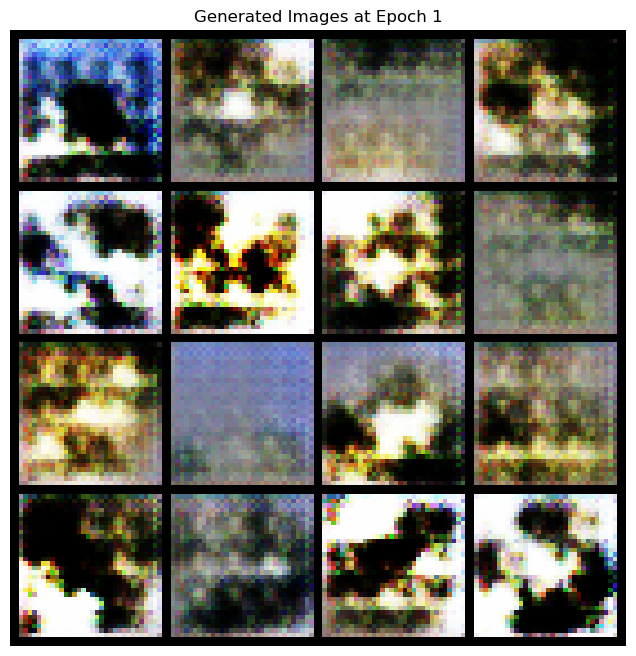

Epoch [2/10]  D Loss: 0.4147  G Loss: 3.5732
Epoch [3/10]  D Loss: 0.4017  G Loss: 3.4560


KeyboardInterrupt: 

In [17]:
# Training Loop
g_losses = []
d_losses = []

# Training Loop (Jupyter Notebook Format)
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # Move images to device
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_imgs = generator(z)

        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_imgs = generator(z)
        g_loss = criterion(discriminator(fake_imgs), real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Save losses for plotting
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}]  D Loss: {d_loss.item():.4f}  G Loss: {g_loss.item():.4f}")

    # Visualize the generated images at certain epochs
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, 1, 1).to(device)
            sample_imgs = generator(z).cpu()
            grid = torchvision.utils.make_grid(sample_imgs, nrow=4, normalize=True)
            plt.figure(figsize=(8, 8))
            plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
            plt.title(f"Generated Images at Epoch {epoch+1}")
            plt.axis("off")
            plt.show()


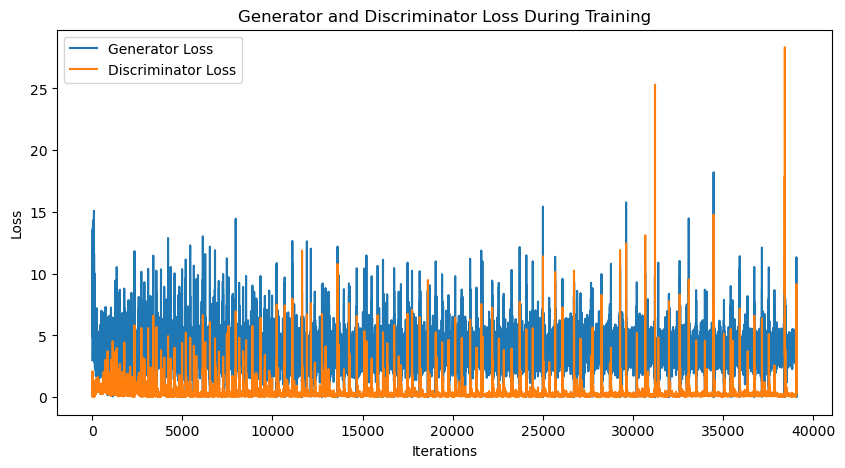

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Loss During Training")
plt.show()


In [ ]:
# Latent Space Interpolation
z_start = torch.randn(1, latent_dim, 1, 1).to(device)
z_end = torch.randn(1, latent_dim, 1, 1).to(device)

# Generate interpolation steps
num_interpolations = 10
interpolated_images = []

for alpha in np.linspace(0, 1, num_interpolations):
    z = (1 - alpha) * z_start + alpha * z_end
    with torch.no_grad():
        interpolated_image = generator(z).cpu()
        interpolated_images.append(interpolated_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99939287..0.9962449].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.999708..0.9973577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999182..0.9957295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99990845..0.9980761].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99982667..0.998324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9996111..0.99690706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9992

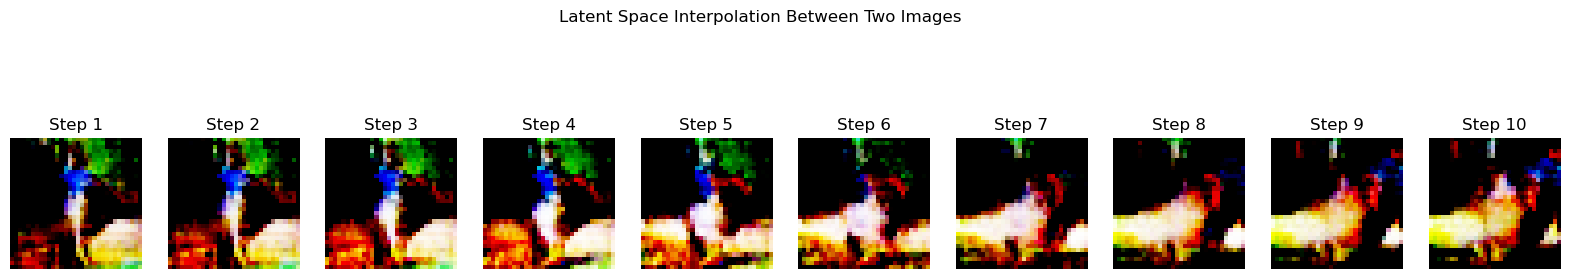

In [ ]:
# Plot interpolated images
plt.figure(figsize=(20, 4))
for i, img in enumerate(interpolated_images):
    plt.subplot(1, num_interpolations, i + 1)
    plt.imshow(np.transpose(img.squeeze().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.title(f"Step {i+1}")
plt.suptitle("Latent Space Interpolation Between Two Images")
plt.show()